<h1>Лабораторная работа 2</h1>
Енгоян Сергей и Ключковский Даниил А-01м-25<br>
Предварительная обработка речевой информации

<h4>Пункт 2 - Загрузка речевой информации и выявление участков голосовой активности

In [226]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import os

In [227]:
def load_audio_soundfile(filename):

    audio_data, sample_rate = sf.read(filename)
    
    # Нормализация
    max_val = np.max(np.abs(audio_data))
    if max_val > 1:
        audio_data = audio_data / max_val

    return audio_data.astype(np.float32), sample_rate

In [228]:
def plot_audio_signal(audio_signal, sample_rate, title="Речевой сигнал"):
    time_axis = np.arange(len(audio_signal)) / sample_rate

    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, audio_signal, linewidth=1)
    plt.title(title)
    plt.xlabel('Время (секунды)')
    plt.ylabel('Амплитуда')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Базовая информация:
 - Частота дискретизации: 48000 Гц
 - Количество сэмплов: 973440
 - Длительность: 20.280 секунд
 - Диапазон значений: [-0.551, 0.222]


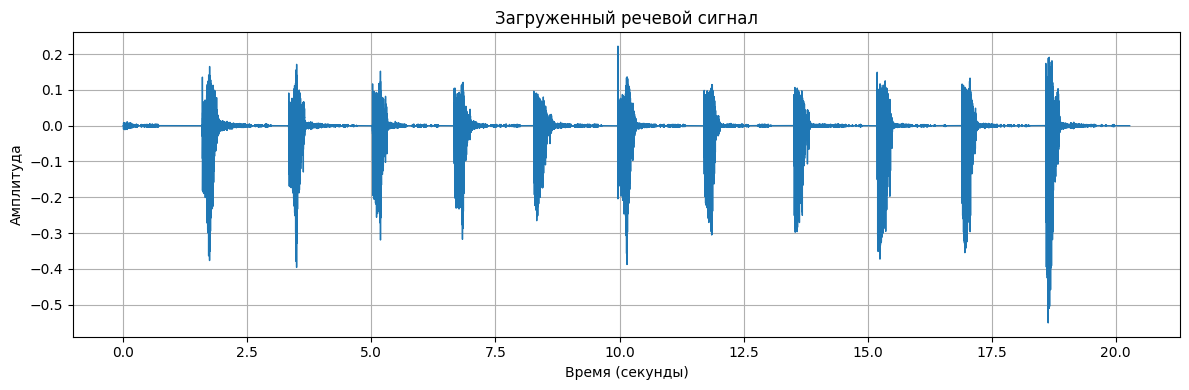

In [229]:
filename = "SOUNDS/record_out.wav"

signal, fs = load_audio_soundfile(filename)

print("Базовая информация:")
print(f" - Частота дискретизации: {fs} Гц")
print(f" - Количество сэмплов: {len(signal)}")
print(f" - Длительность: {len(signal)/fs:.3f} секунд")
print(f" - Диапазон значений: [{np.min(signal):.3f}, {np.max(signal):.3f}]")

plot_audio_signal(signal, fs, "Загруженный речевой сигнал")

In [230]:
def frame_signal(signal, sample_rate, frame_size, overlap):
    '''Разбиение сигнала на кадры с заданным перекрытием
        frame_size - размер кадра в мс
        overlap - степень перекрытия в % (0..100%)
    '''
    frame_size = int(frame_size * sample_rate / 1000)
    step = int(frame_size * (1 - overlap / 100))
    frames = []
    for start in range(0, len(signal) - frame_size, step):
        frame = signal[start:start + frame_size]
        frames.append(frame)
    return np.array(frames)

In [231]:
def short_time_energy(frames):
    energy = np.array([np.sum(frame ** 2) / len(frame) for frame in frames])
    return energy

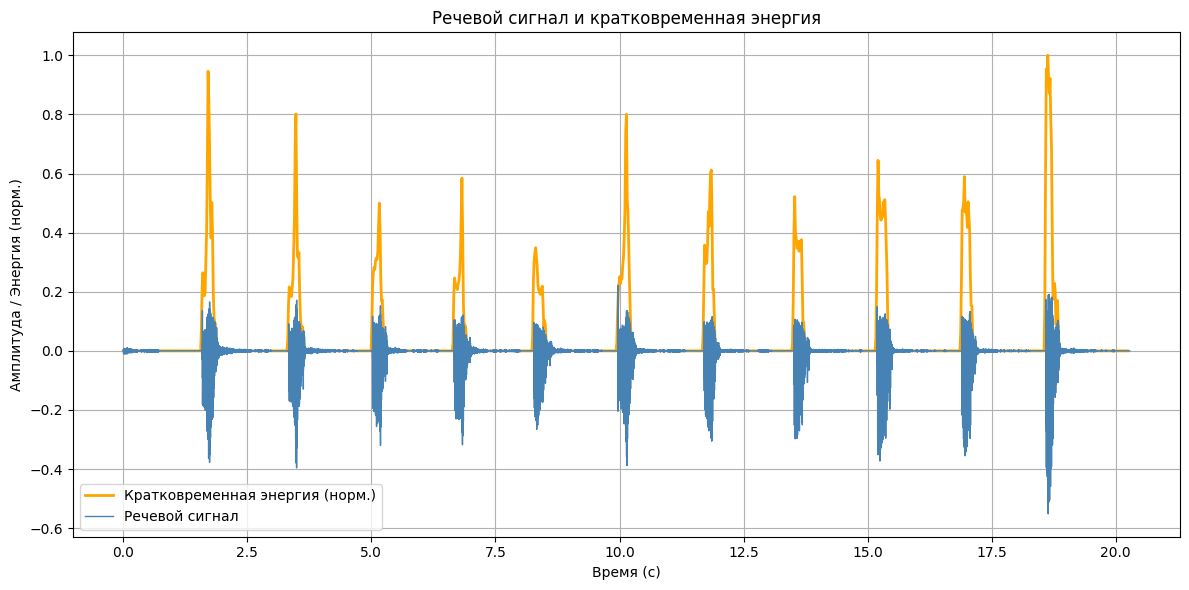

In [232]:
frame_size = 30     #Длительность кадра в мс
overlap = 50        #Степень перекрытия в %

frames = frame_signal(signal, fs, frame_size, overlap)

energy = short_time_energy(frames)
energy_norm = energy / np.max(energy)
time_axis_signal = np.arange(len(signal)) / fs
time_axis_energy = np.arange(len(energy)) * frame_size / 1000 * (1 - overlap / 100)

plt.figure(figsize=(12, 6))
plt.plot(time_axis_energy, energy_norm, label="Кратковременная энергия (норм.)", color='orange', linewidth=2)
plt.plot(time_axis_signal, signal, label="Речевой сигнал", color='steelblue', linewidth=1)
plt.title("Речевой сигнал и кратковременная энергия")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда / Энергия (норм.)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [233]:
def ZCR(frames):
    # Число нулей интенсивности кадра
    zcr = []
    for frame in frames:
        zcr.append(np.sum(np.abs(np.diff(np.sign(frame)))) / 2)
    return zcr

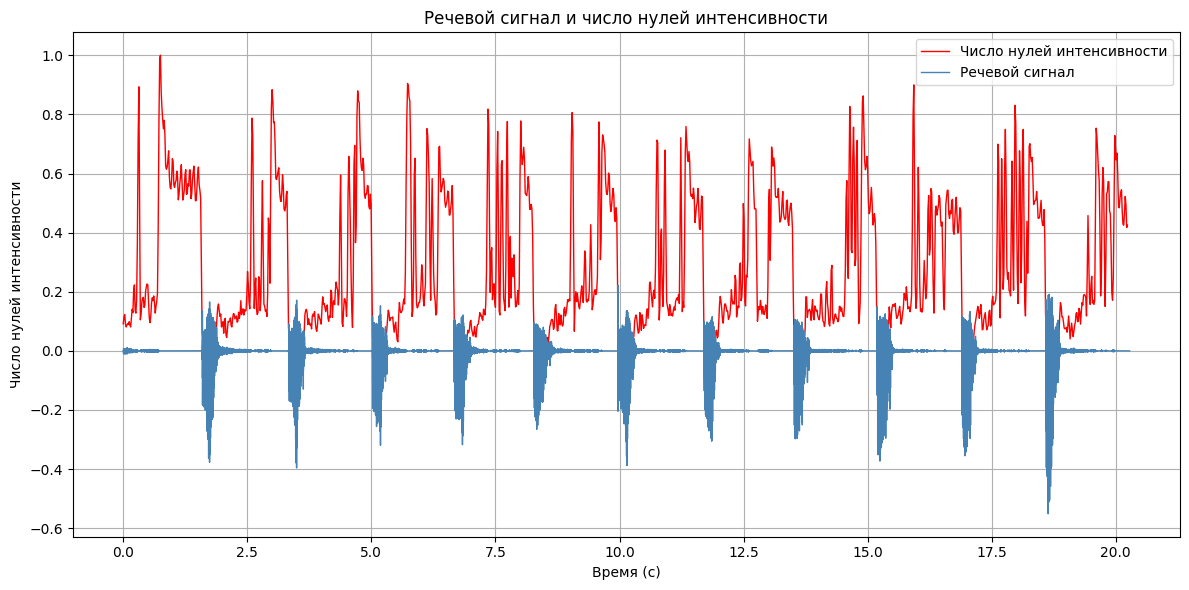

In [252]:
zcr = ZCR(frames)
zcr_norm = zcr / np.max(zcr)

time_axis_signal = np.arange(len(signal)) / fs
time_axis_zcr = np.arange(len(energy)) * frame_size / 1000 * (1 - overlap / 100)

plt.figure(figsize=(12, 6))
plt.plot(time_axis_zcr, zcr_norm, label="Число нулей интенсивности", color='red', linewidth=1)
plt.plot(time_axis_signal, signal, label="Речевой сигнал", color='steelblue', linewidth=1)
plt.title("Речевой сигнал и число нулей интенсивности")
plt.xlabel("Время (с)")
plt.ylabel("Число нулей интенсивности")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

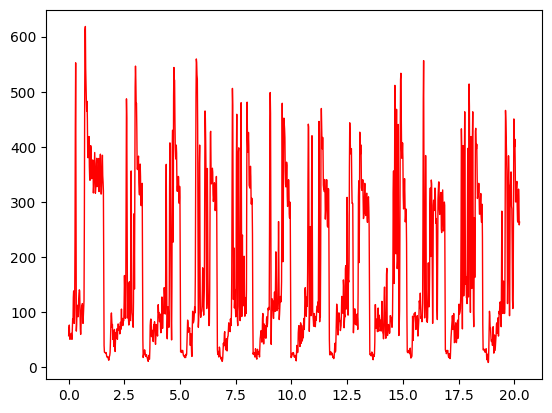

In [253]:
plt.plot(time_axis_zcr, zcr, label="Число нулей интенсивности", color='red', linewidth=1)
plt.show()

In [236]:
def detect_voice_activity(signal, sample_rate, frame_size=30, overlap=50,
                                energy_treshold=0.1, zcr_treshold=0.2, max_gap_ms=100):
    """
    Упрощенная версия с объединением сегментов
    """
    frames = frame_signal(signal, sample_rate, frame_size, overlap)

    energy = short_time_energy(frames)
    energy_tresh = energy_treshold * np.max(energy)

    zcr = ZCR(frames)
    zcr_norm = zcr / np.max(zcr)
    
    voiced_frames = (energy > energy_tresh) & (zcr_norm < zcr_treshold)

    frame_size_samples = int(frame_size * sample_rate / 1000)
    step = int(frame_size_samples * (1 - overlap / 100))

    # Создаем первоначальную маску
    voiced_mask = np.zeros(len(signal), dtype=bool)
    for i, is_voiced in enumerate(voiced_frames):
        if is_voiced:
            start = i * step
            end = min(start + frame_size_samples, len(signal))
            voiced_mask[start:end] = True

    # Простой алгоритм объединения: заполняем короткие разрывы
    max_gap_samples = int(max_gap_ms * sample_rate / 1000)
    
    i = 0
    while i < len(voiced_mask):
        if voiced_mask[i]:
            # Нашли вокализованный участок, пропускаем его
            while i < len(voiced_mask) and voiced_mask[i]:
                i += 1
            
            # Проверяем следующий разрыв
            gap_start = i
            while i < len(voiced_mask) and not voiced_mask[i]:
                i += 1
            gap_end = i
            
            # Если разрыв короткий - заполняем его
            gap_length = gap_end - gap_start
            if 0 < gap_length <= max_gap_samples and i < len(voiced_mask):
                voiced_mask[gap_start:gap_end] = True
        else:
            i += 1
    
    return voiced_mask

In [237]:
def voiced_signal_plot(signal, sample_rate, voiced_mask):
    #Визуализация вокализованных участков
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(signal)) / sample_rate, signal, label="Сигнал", color='steelblue')
    plt.fill_between(np.arange(len(signal)) / sample_rate, np.min(signal), np.max(signal), 
                    where=voiced_mask, alpha=0.3, color='green', label="Вокализованные участки")
    plt.title("Детектирование вокализованных участков")
    plt.xlabel("Время (с)")
    plt.ylabel("Амплитуда")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

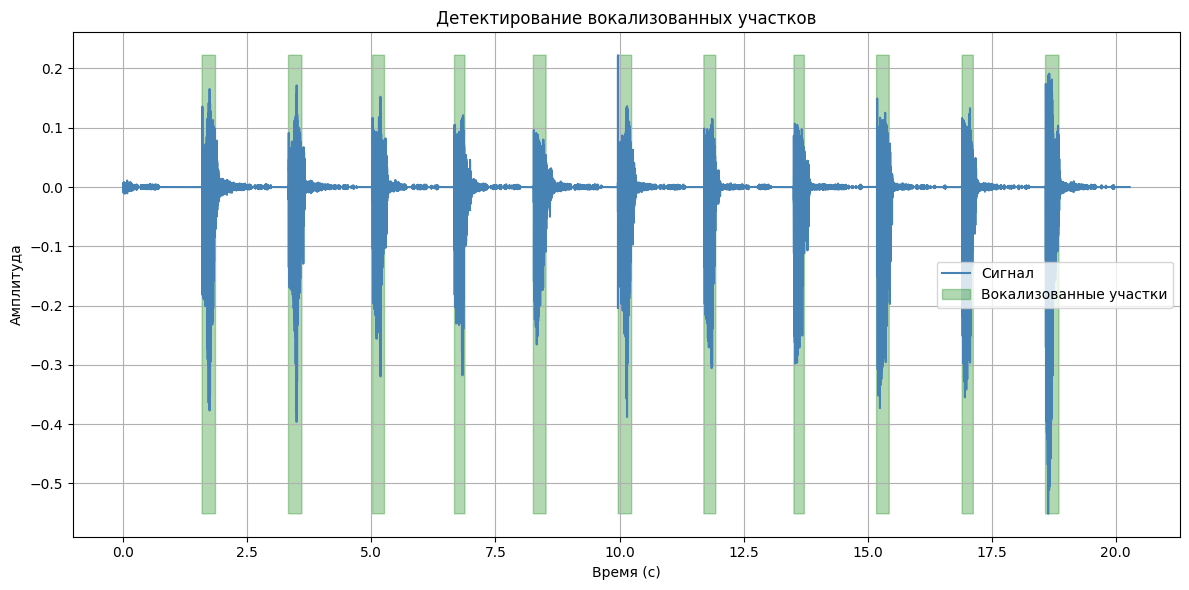

In [238]:
# Детектируем вокализованные участки
voiced_mask = detect_voice_activity(signal, fs, frame_size=30, overlap=50, energy_treshold=0.1, zcr_treshold=0.2)

# Визуализация
voiced_signal_plot(signal, fs, voiced_mask)

In [239]:
def save_voiced_segments(signal, sample_rate, voiced_mask, original_filename, 
                                output_dir="SOUNDS", min_duration=0.1):
    """
    Сохраняет вокализованные участки с фильтрацией по минимальной длительности
    
    Parameters:
    -----------
    min_duration : float
        Минимальная длительность сегмента в секундах
    """
    
    # Создаем имя папки на основе имени файла
    base_name = os.path.splitext(os.path.basename(original_filename))[0]
    segment_dir = os.path.join(output_dir, base_name)
    os.makedirs(segment_dir, exist_ok=True)
    
    # Находим границы сегментов
    segments = []
    start = None
    
    for i, is_voiced in enumerate(voiced_mask):
        if is_voiced and start is None:
            start = i
        elif not is_voiced and start is not None:
            segments.append((start, i))
            start = None
    
    if start is not None:
        segments.append((start, len(voiced_mask)))
    
    # Фильтруем сегменты по минимальной длительности
    min_samples = int(min_duration * sample_rate)
    filtered_segments = [(s, e) for s, e in segments if (e - s) >= min_samples]
    
    # Сохраняем сегменты
    saved_files = []
    for i, (start_idx, end_idx) in enumerate(filtered_segments):
        segment = signal[start_idx:end_idx]
        duration = len(segment) / sample_rate
        
        filename = os.path.join(segment_dir, f"{base_name}_segment_{i+1:03d}.wav")
        sf.write(filename, segment, sample_rate)
        saved_files.append(filename)
        
        print(f"Сохранен сегмент {i+1}: {filename} (длина: {duration:.2f} сек)")
    return saved_files, filtered_segments

In [254]:
save_voiced_segments(signal, fs, voiced_mask, original_filename="record_out", min_duration=0.1)
print()

Сохранен сегмент 1: SOUNDS\record_out\record_out_segment_001.wav (длина: 0.27 сек)
Сохранен сегмент 2: SOUNDS\record_out\record_out_segment_002.wav (длина: 0.27 сек)
Сохранен сегмент 3: SOUNDS\record_out\record_out_segment_003.wav (длина: 0.24 сек)
Сохранен сегмент 4: SOUNDS\record_out\record_out_segment_004.wav (длина: 0.21 сек)
Сохранен сегмент 5: SOUNDS\record_out\record_out_segment_005.wav (длина: 0.26 сек)
Сохранен сегмент 6: SOUNDS\record_out\record_out_segment_006.wav (длина: 0.27 сек)
Сохранен сегмент 7: SOUNDS\record_out\record_out_segment_007.wav (длина: 0.24 сек)
Сохранен сегмент 8: SOUNDS\record_out\record_out_segment_008.wav (длина: 0.21 сек)
Сохранен сегмент 9: SOUNDS\record_out\record_out_segment_009.wav (длина: 0.26 сек)
Сохранен сегмент 10: SOUNDS\record_out\record_out_segment_010.wav (длина: 0.23 сек)
Сохранен сегмент 11: SOUNDS\record_out\record_out_segment_011.wav (длина: 0.27 сек)



<h4>Пункт 3 - Шумоочистка

Базовая информация:
 - Частота дискретизации: 24000 Гц
 - Количество сэмплов: 1453027
 - Длительность: 60.543 секунд
 - Диапазон значений: [-0.444, 0.381]


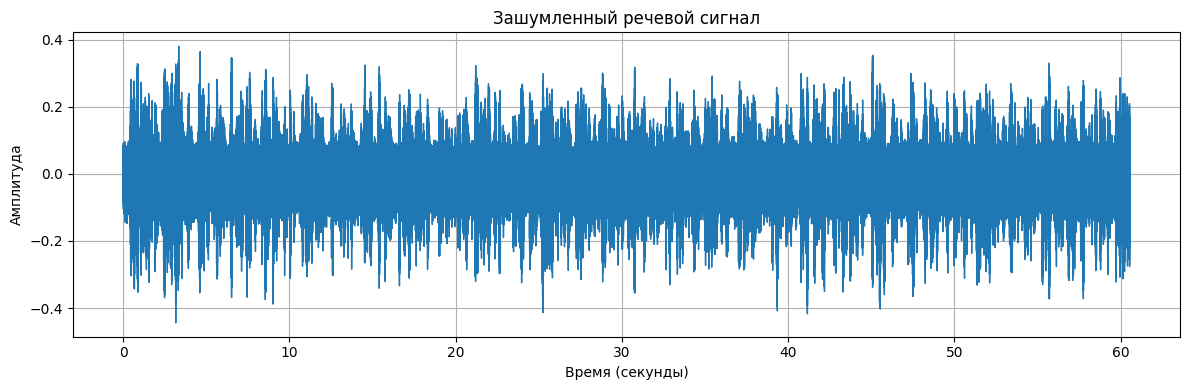

In [241]:
noised_file = "SOUNDS/Y.wav"

noised_signal, fs_noised = load_audio_soundfile(noised_file)

print("Базовая информация:")
print(f" - Частота дискретизации: {fs_noised} Гц")
print(f" - Количество сэмплов: {len(noised_signal)}")
print(f" - Длительность: {len(noised_signal)/fs_noised:.3f} секунд")
print(f" - Диапазон значений: [{np.min(noised_signal):.3f}, {np.max(noised_signal):.3f}]")

plot_audio_signal(noised_signal, fs_noised, "Зашумленный речевой сигнал")

In [242]:
def low_pass_filter(signal, sample_rate, cutoff_freq=1500):

    nyquist = sample_rate / 2.0
    normalized_cutoff = cutoff_freq / nyquist

    numtaps = 101
    taps = np.sinc(normalized_cutoff * (np.arange(numtaps) - (numtaps - 1) / 2))
    taps *= np.hamming(numtaps)

    taps = taps / np.sum(taps)

    filtered_signal = np.convolve(signal, taps, mode='same')
    
    return filtered_signal

In [243]:
import librosa

def spectral_subtraction(noised_signal, sample_rate, noise_estimate=None, frame_size=1024, hop_size=512, alpha=4.0, beta=0.002):
    """
    Параметры:
    ----------
    noise_estimate : np.ndarray или None
        Участок с шумом для оценки спектра шума
    frame_size : int
        Размер окна для STFT
    hop_size : int
        Шаг окна
    alpha : float
        Коэффициент подавления шума (обычно 3–6)
    beta : float
        Минимальный уровень остаточного шума (шумовой порог)
    """

    # === 1. STFT ===
    stft_noised = librosa.stft(noised_signal, n_fft=frame_size, hop_length=hop_size, win_length=frame_size)
    magnitude = np.abs(stft_noised)
    phase = np.angle(stft_noised)

    # === 2. Оценка спектра шума ===
    if noise_estimate is None:
        # Если шум не указан, берём первые 10 кадров как шум
        noise_estimate = magnitude[:, :10]
    noise_mean = np.mean(noise_estimate, axis=1, keepdims=True)

    # === 3. Вычитание спектров ===
    # По схеме: |Xw| = max(|X| - α|N|, β|X|)
    subtracted = magnitude - alpha * noise_mean
    subtracted = np.maximum(subtracted, beta * magnitude)

    # === 4. Восстановление комплексного спектра ===
    stft_clean = subtracted * np.exp(1j * phase)

    # === 5. Обратное преобразование (overlap-add) ===
    cleaned_signal = librosa.istft(stft_clean, hop_length=hop_size, win_length=frame_size)

    return cleaned_signal
    

In [244]:
def signals_psd_compare(original_signal, filtered_signal, sample_rate, title='Сравнение спектральной плотности мощности'):
    from scipy.signal import welch
    """Сравнение спектральной плотности мощности (PSD)"""
    plt.figure(figsize=(12, 5))

    # Используем метод Welch для оценки PSD
    f1, Pxx1 = welch(original_signal, fs=sample_rate, nperseg=1024)
    f2, Pxx2 = welch(filtered_signal, fs=sample_rate, nperseg=1024)

    plt.semilogy(f1, Pxx1, label='Исходный (с шумом)')
    plt.semilogy(f2, Pxx2, label='После фильтрации')
    plt.xlabel('Частота, Гц')
    plt.ylabel('Плотность мощности')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [245]:
def signals_compare(signal1, signal2, sample_rate, title='Сравнение сигналов'):
    time_axis_signal = np.arange(len(signal1)) / sample_rate

    plt.figure(figsize=(12, 6))
    plt.plot(time_axis_signal, signal1, label="Зашумленный сигнал", color='red', linewidth=1)
    plt.plot(time_axis_signal, signal2, label="Очищенный сигнал",alpha=0.9, color='steelblue', linewidth=1)
    plt.title("Зашемленный и очищенный сигнал")
    plt.xlabel("Время (с)")
    plt.ylabel("Амплитуда")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


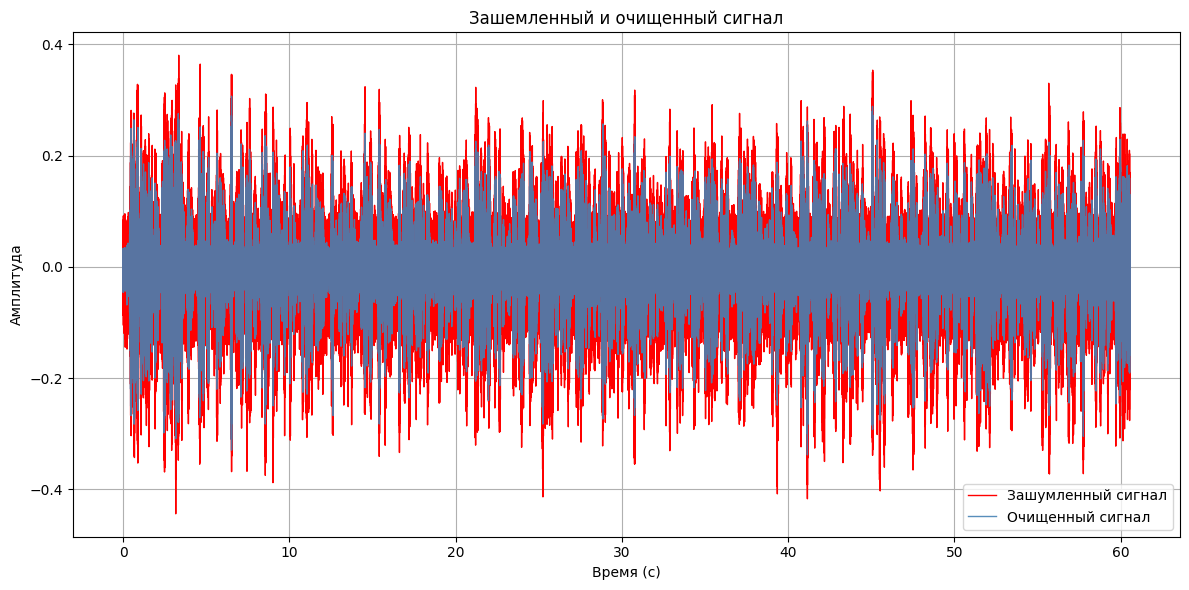

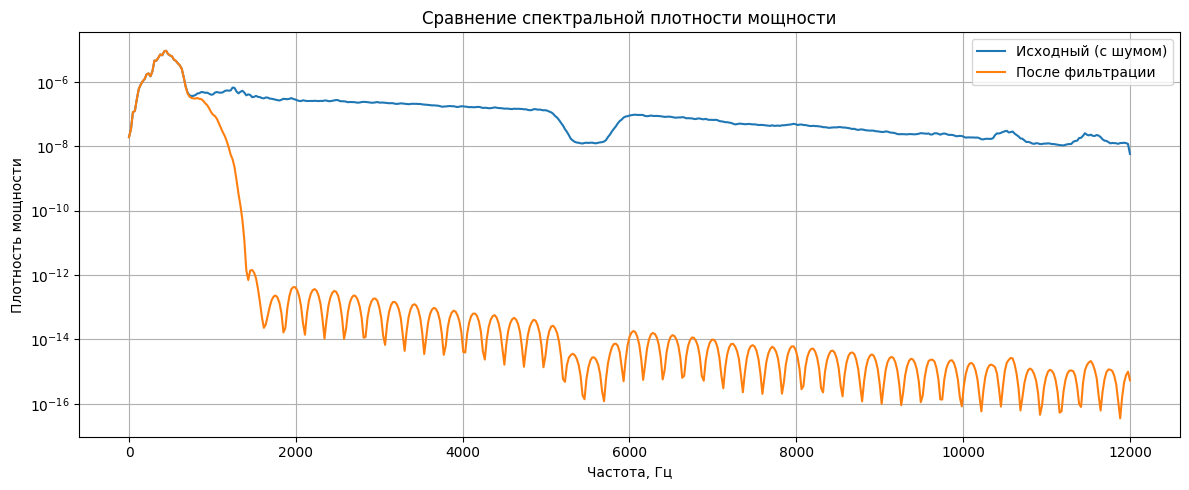

In [246]:
filtered_signal_low = low_pass_filter(noised_signal, fs_noised, cutoff_freq=1000)

signals_compare(noised_signal, filtered_signal_low, fs_noised)

signals_psd_compare(noised_signal, filtered_signal_low, fs_noised)

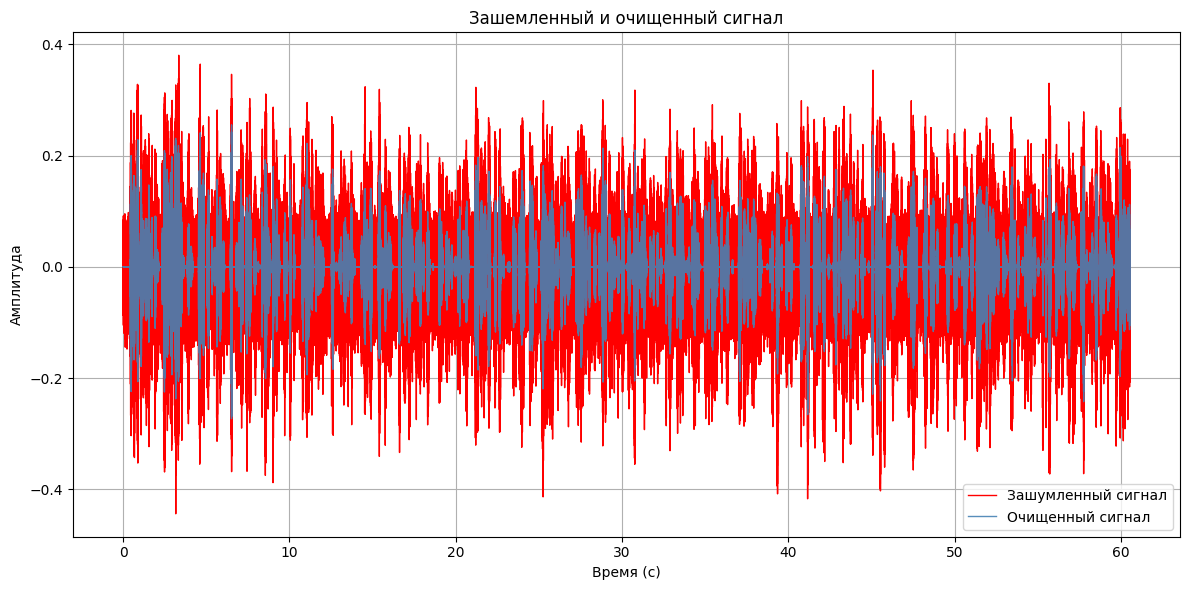

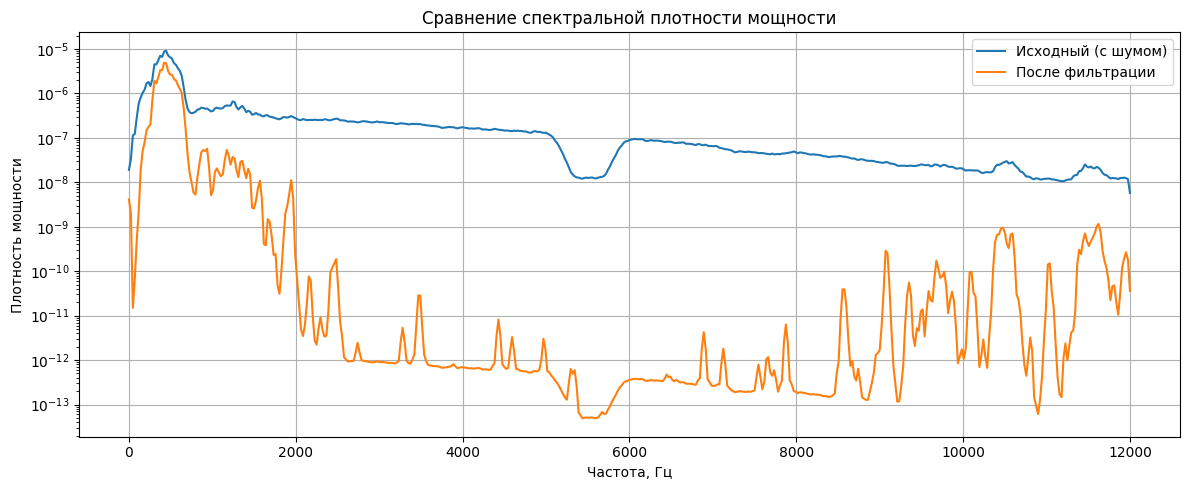

In [247]:
filtered_signal_SS = spectral_subtraction(noised_signal, fs_noised, alpha=4.5, beta=0.002)

min_len = min(len(noised_signal), len(filtered_signal_SS))
noised_signal_short = noised_signal[:min_len]
filtered_signal_SS_short = filtered_signal_SS[:min_len]

signals_compare(noised_signal_short, filtered_signal_SS_short, fs_noised)

signals_psd_compare(noised_signal_short, filtered_signal_SS_short, fs_noised)

In [248]:
def save_audio(filename, signal, sample_rate):
    # Формируем новое имя
    output_path= "SOUNDS/"
    output_filename = output_path + filename + ".wav"

    # Сохраняем как 32-битный float WAV
    sf.write(output_filename, signal, sample_rate, subtype='FLOAT')

    print(f"Файл сохранён: {output_filename}")

In [249]:
save_audio("Y_denoised_low", filtered_signal_low, fs_noised)
save_audio("Y_denoised_SS", filtered_signal_SS, fs_noised)

Файл сохранён: SOUNDS/Y_denoised_low.wav
Файл сохранён: SOUNDS/Y_denoised_SS.wav


Пункт 4 - Запись аудиофайла

In [250]:
import sounddevice as sd

def record_audio_sounddevice(filename=None, sample_rate=22050):
    """
    Запись аудио с микрофона и сохранение в WAV-файл.
    Если имя файла не указано, запрашивается у пользователя.
    """

    print("=== Запись аудио ===")
    print("Нажмите Enter для начала записи")
    print("Снова нажмите Enter для остановки записи")
    print("Нажмите Ctrl+C для отмены\n")

    # Если имя файла не передано — запросить у пользователя
    if not filename:
        filename = input("Введите имя файла для сохранения (без .wav): ").strip()
        if not filename:
            filename = "recorded_audio"
        if not filename.endswith(".wav"):
            filename += ".wav"

    input("Нажмите Enter, чтобы начать запись...")

    print("\nЗАПИСЬ НАЧАТА... Говорите!")
    print("Нажмите Enter, чтобы остановить запись")

    recording = []

    def callback(indata, frames, time, status):
        recording.append(indata.copy())

    try:
        with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16', callback=callback):
            input()  # Ожидаем Enter для остановки
    except KeyboardInterrupt:
        print("\nЗапись прервана пользователем.")
        return

    print("ЗАПИСЬ ОСТАНОВЛЕНА")

    # Сохранение в WAV
    if recording:
        audio_data = np.vstack(recording)
        sf.write(filename, audio_data, sample_rate, subtype='PCM_16')
        duration = len(audio_data) / sample_rate
        print(f"💾 Аудио сохранено: {filename}")
        print(f"⏱️ Длительность: {duration:.2f} секунд")
    else:
        print("Запись пуста — файл не создан.")

Запись голосовых команд

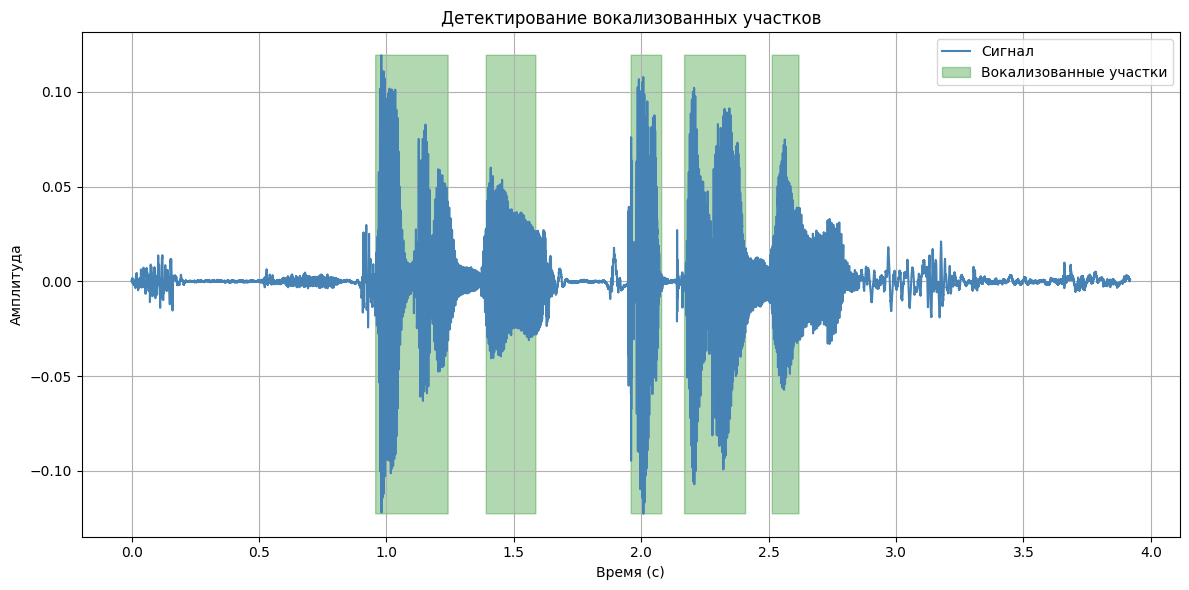

In [268]:
# filename = "word"
# output_filename = f"SOUNDS/{filename}.wav"
# # record_audio_sounddevice(output_filename)

# command, fs_command = load_audio_soundfile(output_filename)

# voiced_mask_command = detect_voice_activity(command, fs_command, energy_treshold=0.1, zcr_treshold=0.5, max_gap_ms=300)
# voiced_signal_plot(command, fs_command, voiced_mask_command)
# save_voiced_segments(command, fs_command, voiced_mask_command, output_filename, min_duration=0.1)
# print()